In order to import the data and allow the notebook to access files, we mount Google Drive and grant permissions.

In [ ]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


Let's also import any libraries that we will be needing here.

In [ ]:
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next, we read our CSV file from the appropriate directory and store it as a 2D array of strings. We will store the data in a pandas dataFrame which is easily compatible with tensorflow. The dataFrame behaves as a 2D array which means lookups are efficient.

The CSV should follow a certain format: the first two rows are headers and labels and the remaining rows contain data. The data is entered without any particular type.

In [ ]:
#find the path to our CSV file within google drive and pass it as an argument to the open call.
#the path will begin with /content/drive/My Drive/ in most cases.
CHFdata = pd.read_csv('/content/drive/My Drive/Heart Failure AI/CHF Data.csv', header=1, dtype=str)
CHFdata.dtypes

monty, year, case #                                            object
Admission Date                                                 object
Age                                                            object
Gender                                                         object
BMI                                                            object
Zip Code                                                       object
Echocardiogram LVEF (%)                                        object
Troponin (highest)                                             object
Hemoglobin A1C                                                 object
Creat (Chem 7 within 24 hours of admission)                    object
GFR                                                            object
BNP (Initial, B-type naturetic peptide)                        object
Urine Tox negative (0) or per history                          object
Urine Tox Pos Stimulant (1)                                    object
Urine Tox Pos Benzo 

In [ ]:
CHFdata

,"monty, year, case #",Admission Date,Age,Gender,BMI,Zip Code,Echocardiogram LVEF (%),Troponin (highest),Hemoglobin A1C,Creat (Chem 7 within 24 hours of admission),GFR,"BNP (Initial, B-type naturetic peptide)",Urine Tox negative (0) or per history,Urine Tox Pos Stimulant (1),Urine Tox Pos Benzo (2),Urine Tox Positive Opiate (3),Urine Tox Positive THC (4),Smoking Currently (Yes/ No),Former Smoker,Smoking (Pack Year History),Marijuana (THC),Alcohol (low/high),30 day readmission,60 day readmission,30 day death,60 day death,90 day death,DM,Hypertension,Coronary Artery Disease,Prior Stroke / TIA / Cerebral Vascular Ischemia,Atrial Fibrillation,Peripheral vascular disease,Obstructive Sleep Apnea,"Aortic Stenosis 0 = No, 1= yes / mild, 2=moderate, 3=severe",Dialysis
0,1,3/31/2018,78,M,26.22,95828,65,0.11,6.5,1.19,58,454,0,0,0,0,0,0,1,20,0,0,No,No,No,No,No,Yes,Yes,No,No,Yes,No,No,NaN,NaN
1,2,4/3/2018,66,M,28.18,95833,15,0.03,5.5,1.78,45,2103,0,0,0,0,0,0,1,38,0,1,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,No,NaN,NaN
2,3,4/6/2018,86,M,19.77,95691,31,0.11,5.5,1.32,52,136,0,0,0,0,0,0,1,31,0,0,No,No,No,No,No,Yes,Yes,Yes,No,No,No,No,NaN,NaN
3,4,4/6/2018,79,M,23.4,95829,35,0.06,5.4,2.37,29,1362,0,0,0,0,0,0,1,0,0,1,Yes,No,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,NaN,NaN
4,5,4/7/2018,58,M,31.13,94565,49,0.44,5.5,2.17,31,180,1,0,1,1,0,0,1,34,1,0,Yes,Yes,No,No,No,No,Yes,Yes,No,Yes,No,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,101815,10/20/18,78,M,23.1,95831,33,0.03,5.5,0.87,83,1745,0,0,0,0,0,0,1,50,0,0,No,No,No,No,No,No,Yes,No,No,Yes,No,No,0,No
116,101816,10/14/18,81,F,16.59,95824,65,0.02,6.6,2.29,19,1372,0,0,0,0,0,0,0,0,0,0,No,Yes,No,No,No,Yes,Yes,Yes,No,No,No,No,0,No
117,101817,10/2/18,68,F,38.74,95822,42,0.05,11.4,1.13,58,278,0,0,0,0,0,0,0,0,0,0,Yes,No,No,No,No,Yes,Yes,Yes,No,No,Yes,Yes,0,No
118,101818,10/10/18,78,M,29.95,95822,19,0.05,6.6,1.03,69,1798,0,0,0,0,0,0,1,20,0,1,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,0,No


We see that our data is stored in the type "object" which encompasses the python string type, str, alongside other types. However, we would want to store some values such as booleans or floats so that they represent actual values rather than characters. Also, we want to make sure that each column is made up of a single data type rather than a mixture which is why integers are stored as floats. (XGBoost can work with missing data fields but each missing entry is treated as a NaN).

In [ ]:
#convert yes and no to True and False respectively as a bool
yesNoList = ['30 day readmission', '60 day readmission', '30 day death', '60 day death', '90 day death', 'DM', 'Hypertension',
             'Coronary Artery Disease', 'Prior Stroke / TIA / Cerebral Vascular Ischemia', 'Atrial Fibrillation', 
             'Peripheral vascular disease', 'Obstructive Sleep Apnea', 'Dialysis']
#convert 1 and 0 to True and False respectively as a bool
intBoolList = ['Urine Tox negative (0) or per history', 'Urine Tox Pos Stimulant (1)', 'Urine Tox Pos Benzo (2)',
               'Urine Tox Positive Opiate (3)', 'Urine Tox Positive THC (4)', 'Smoking Currently (Yes/ No)', 'Former Smoker',
               'Marijuana (THC)', 'Alcohol (low/high)']
#convert strings to appropirate types
convert_dict = {'Age': float, 'BMI': float, 'Echocardiogram LVEF (%)': float, 'Troponin (highest)': float, 'Hemoglobin A1C': float, 'Creat (Chem 7 within 24 hours of admission)': float, 'BNP (Initial, B-type naturetic peptide)': float, 'GFR': float, 'DM': bool, 'Prior Stroke / TIA / Cerebral Vascular Ischemia': bool, 'Atrial Fibrillation': bool, 'Peripheral vascular disease': bool, 'Obstructive Sleep Apnea': bool, 'Gender': bool, 'Smoking (Pack Year History)': float, 'Marijuana (THC)': float, 'Alcohol (low/high)': float, 'Aortic Stenosis 0 = No, 1= yes / mild, 2=moderate, 3=severe': float} 
for i in yesNoList:
    CHFdata[i] = CHFdata[i].map({'Yes':True, 'No':False, ' Yes':True, ' No':False})
for j in intBoolList:
    CHFdata[j] = CHFdata[j].map({'1':True, '0':False})
CHFdata['Gender'] = CHFdata['Gender'].map({'M': False, 'F': True})
CHFdata = CHFdata.astype(convert_dict) 
CHFdata.dtypes

monty, year, case #                                             object
Admission Date                                                  object
Age                                                            float64
Gender                                                            bool
BMI                                                            float64
Zip Code                                                        object
Echocardiogram LVEF (%)                                        float64
Troponin (highest)                                             float64
Hemoglobin A1C                                                 float64
Creat (Chem 7 within 24 hours of admission)                    float64
GFR                                                            float64
BNP (Initial, B-type naturetic peptide)                        float64
Urine Tox negative (0) or per history                             bool
Urine Tox Pos Stimulant (1)                                       bool
Urine 

Using matplotlib, we can visualize some of the data and perform some simple data analysis. Visualizing the data can also help to pinpoint sources of bias. Tools in the seaborn library allow us to plot a histogram and density curve together for easy visualization.

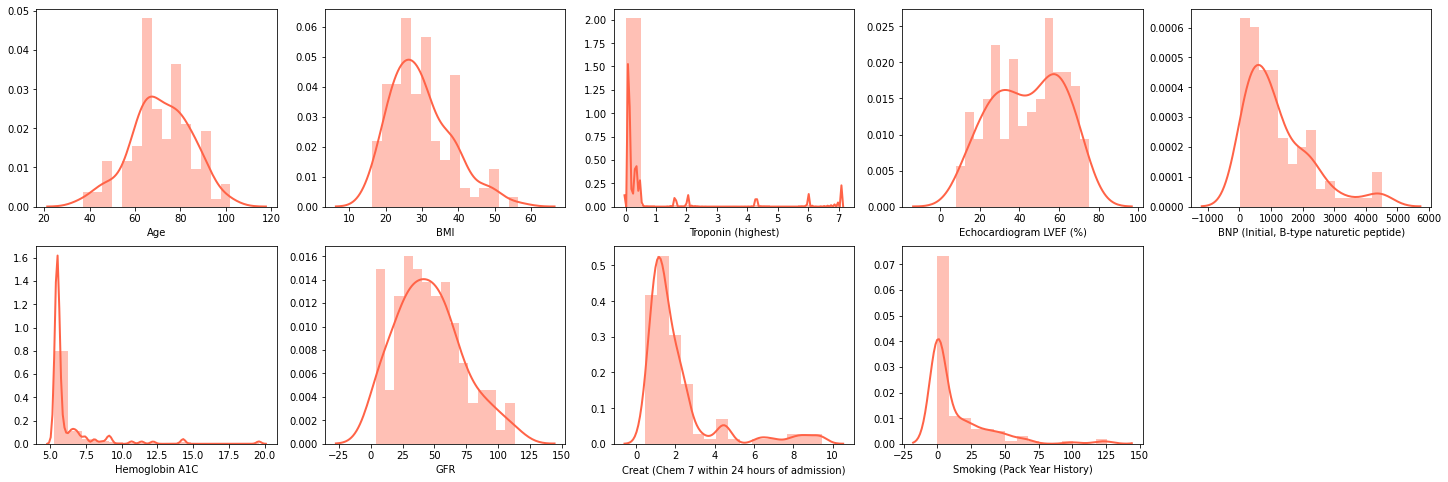

In [ ]:
graphList = ['Age','BMI','Troponin (highest)','Echocardiogram LVEF (%)','BNP (Initial, B-type naturetic peptide)','Hemoglobin A1C','GFR','Creat (Chem 7 within 24 hours of admission)','Smoking (Pack Year History)']
graphs = plt.figure(figsize=(25,8))
#plt.title('Patient Data Distributions')
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(2,5,k)
    sns.distplot(CHFdata[graphList[k-1]], hist=True, kde=True, bins=int(len(CHFdata)/8), color = 'tomato', kde_kws={'linewidth': 2})
    #plt.ylabel('Frequency')
    #plt.title(graphList[k-1] + ' distribution')

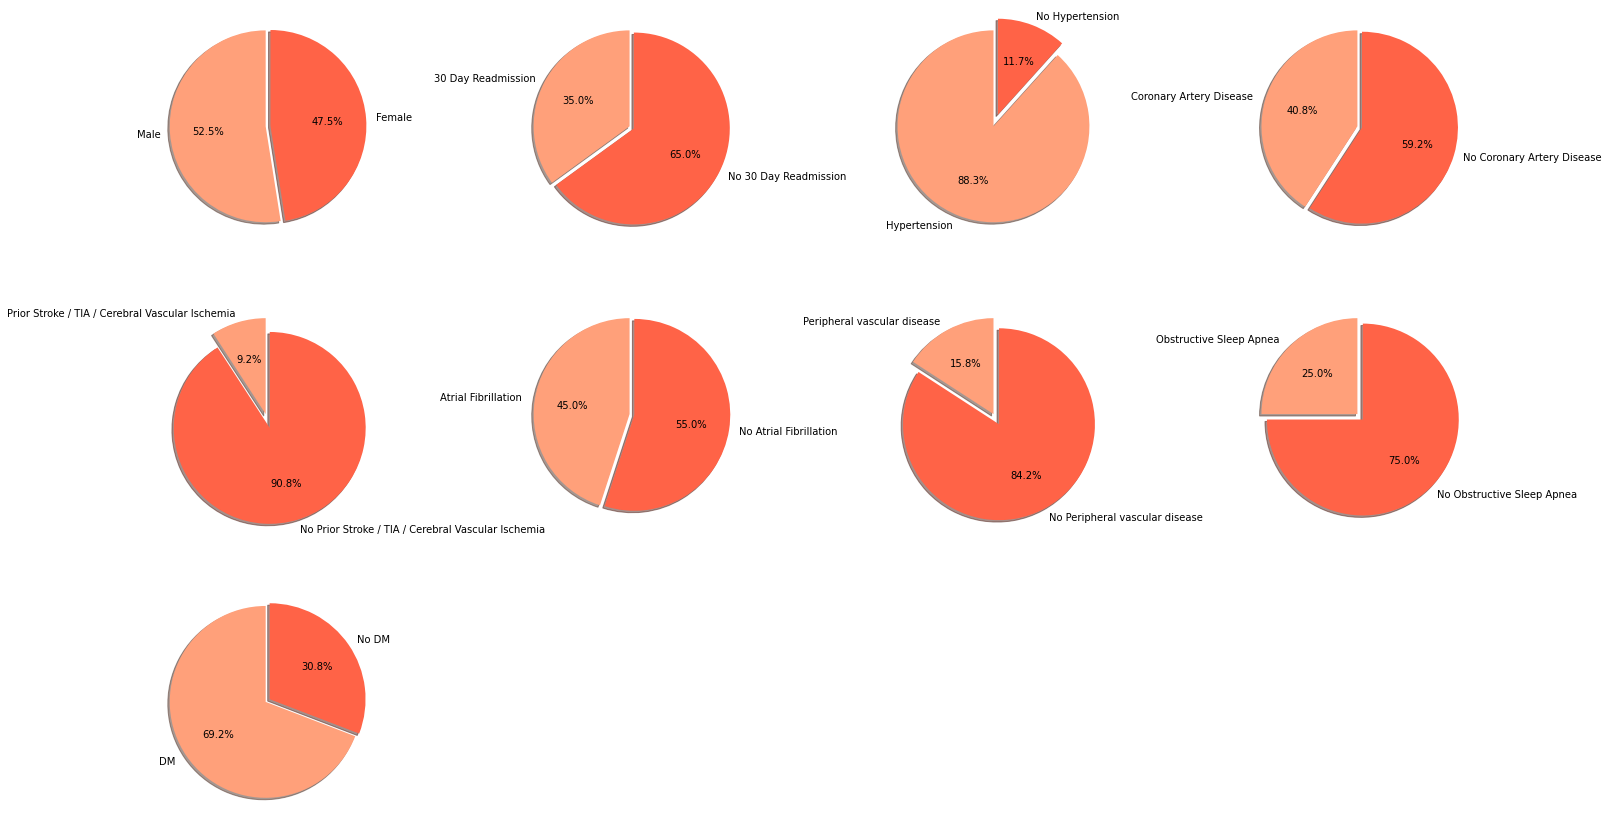

In [ ]:
pie = plt.figure(figsize=(25,15))

pie.add_subplot(3,4,1)
sizes = [CHFdata.loc[CHFdata['Gender'] == False].shape[0], CHFdata.loc[CHFdata['Gender'] == True].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Male', 'Female'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,2)
sizes = [CHFdata.loc[CHFdata['30 day readmission'] == 1].shape[0], CHFdata.loc[CHFdata['30 day readmission'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['30 Day Readmission', 'No 30 Day Readmission'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,3)
sizes = [CHFdata.loc[CHFdata['Hypertension'] == 1].shape[0], CHFdata.loc[CHFdata['Hypertension'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.13), labels=['Hypertension ', 'No Hypertension'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,4)
sizes = [CHFdata.loc[CHFdata['Coronary Artery Disease'] == 1].shape[0], CHFdata.loc[CHFdata['Coronary Artery Disease'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Coronary Artery Disease ', 'No Coronary Artery Disease'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,5)
sizes = [CHFdata.loc[CHFdata['Prior Stroke / TIA / Cerebral Vascular Ischemia'] == 1].shape[0], CHFdata.loc[CHFdata['Prior Stroke / TIA / Cerebral Vascular Ischemia'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.15), labels=['Prior Stroke / TIA / Cerebral Vascular Ischemia', 'No Prior Stroke / TIA / Cerebral Vascular Ischemia'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,6)
sizes = [CHFdata.loc[CHFdata['Atrial Fibrillation'] == 1].shape[0], CHFdata.loc[CHFdata['Atrial Fibrillation'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Atrial Fibrillation ', 'No Atrial Fibrillation'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,7)
sizes = [CHFdata.loc[CHFdata['Peripheral vascular disease'] == 1].shape[0], CHFdata.loc[CHFdata['Peripheral vascular disease'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.12), labels=['Peripheral vascular disease ', 'No Peripheral vascular disease'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,8)
sizes = [CHFdata.loc[CHFdata['Obstructive Sleep Apnea'] == 1].shape[0], CHFdata.loc[CHFdata['Obstructive Sleep Apnea'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.08), labels=['Obstructive Sleep Apnea ', 'No Obstructive Sleep Apnea'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,9)
sizes = [CHFdata.loc[CHFdata['DM'] == 1].shape[0], CHFdata.loc[CHFdata['DM'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['DM ', 'No DM'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

This application will use XGBoost as the machine learning algorithm since we are working on a relatively small dataset. Additionally we can take advantage of the features of XGBoost such as the ability to handle missing data which is common in our dataset and the ability to reasonably damped overfitting.

First, lets load and prepare our data to use with XGBoost. We can specify what factors we want to include in an array. Lets try using just 3 factors for input, and the 30 day readmittance for our output.

In [ ]:
inputColumns = ["Age", "Gender", "BMI", "Echocardiogram LVEF (%)", "Troponin (highest)",
                "Hemoglobin A1C" ,"Creat (Chem 7 within 24 hours of admission)", "GFR",
                "BNP (Initial, B-type naturetic peptide)", "DM",  "Coronary Artery Disease",
                "Prior Stroke / TIA / Cerebral Vascular Ischemia", "Atrial Fibrillation",
                "Peripheral vascular disease", "Obstructive Sleep Apnea", "Hypertension",
                "Smoking (Pack Year History)", "Former Smoker"]
outputColumn = '30 day readmission'

inputData = CHFdata[inputColumns]
outputData = CHFdata[outputColumn]

print(inputData)
print(outputData)

      Age  Gender  ...  Smoking (Pack Year History)  Former Smoker
0    78.0   False  ...                         20.0           True
1    66.0   False  ...                         38.0           True
2    86.0   False  ...                         31.0           True
3    79.0   False  ...                          0.0           True
4    58.0   False  ...                         34.0           True
..    ...     ...  ...                          ...            ...
115  78.0   False  ...                         50.0           True
116  81.0    True  ...                          0.0          False
117  68.0    True  ...                          0.0          False
118  78.0   False  ...                         20.0           True
119  70.0   False  ...                         30.0           True

[120 rows x 18 columns]
0      False
1       True
2      False
3       True
4       True
       ...  
115    False
116    False
117     True
118    False
119    False
Name: 30 day readmission, Le

Lets set some parameters for XGBoost and split our data into a training set and a testing set. We use a seed for a random number generator which ensures that the split is consistent for each round of execution.

In [ ]:
inputTrain, inputTest, outputTrain, outputTest = train_test_split(inputData, outputData, test_size = .3, random_state = 2)

Now we can begin to train the model.

In [ ]:
model = xgb.XGBClassifier()
model.fit(inputTrain, outputTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import accuracy_score
outputPred = model.predict(inputTest)
predictions = [round(value) for value in outputPred]
accuracy = accuracy_score(outputTest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.44%


The above section is a simpler model with less training and less accuracy but gives a rough estimate of what we will see. It would be helpful to have some additional information during the training process as well. Lets start with training with set, hard-coded parameters for the generated tree.

In [ ]:
trainMatrix = xgb.DMatrix(inputTrain, label=outputTrain, feature_names=inputColumns[:18])
testMatrix = xgb.DMatrix(inputTest, label=outputTest, feature_names=inputColumns[:18])
params = {'max_depth':5, 'eta':0.004, 'subsample':1.0, 'min_child_weight':1.0, 'reg_lambda':0.0, 'reg_alpha':0.0, 'objective':'binary:logistic', 'eval_metric': 'error'}
model = xgb.train(params, trainMatrix, 1000, evals=[(testMatrix, "Test")], early_stopping_rounds=200)

[0]	Test-error:0.305556
Will train until Test-error hasn't improved in 200 rounds.
[1]	Test-error:0.305556
[2]	Test-error:0.305556
[3]	Test-error:0.305556
[4]	Test-error:0.305556
[5]	Test-error:0.305556
[6]	Test-error:0.305556
[7]	Test-error:0.305556
[8]	Test-error:0.305556
[9]	Test-error:0.305556
[10]	Test-error:0.305556
[11]	Test-error:0.305556
[12]	Test-error:0.305556
[13]	Test-error:0.305556
[14]	Test-error:0.305556
[15]	Test-error:0.305556
[16]	Test-error:0.305556
[17]	Test-error:0.305556
[18]	Test-error:0.305556
[19]	Test-error:0.305556
[20]	Test-error:0.305556
[21]	Test-error:0.305556
[22]	Test-error:0.305556
[23]	Test-error:0.305556
[24]	Test-error:0.305556
[25]	Test-error:0.305556
[26]	Test-error:0.305556
[27]	Test-error:0.305556
[28]	Test-error:0.305556
[29]	Test-error:0.305556
[30]	Test-error:0.305556
[31]	Test-error:0.305556
[32]	Test-error:0.305556
[33]	Test-error:0.305556
[34]	Test-error:0.305556
[35]	Test-error:0.305556
[36]	Test-error:0.305556
[37]	Test-error:0.305556
[

Now we find the parameters the correspond to the lowest amount of error. This is the portion of the code that takes a considerable amount of time. With more parameters tested comes and increase in runtime but also an decrease in the error.

In [ ]:
param_grid = {'eta':[.3,.25,.2,.15,0.1,.075,0.05,0.01,0.005,0.001], 'max_depth':np.arange(1,10,1).tolist(), 'subsample':np.arange(1,0.1,-0.1).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.1).tolist(), 'min_child_weight':np.arange(1,100,5).tolist()}

#Save the best results
bestParams = {}
lowestError = 2048

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:
                    cvResults = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}, trainMatrix, num_boost_round=600, seed=2, nfold=5, early_stopping_rounds=125)
                    if cvResults['test-{}-mean'.format('error')].min() < lowestError:
                        lowestError = cvResults['test-{}-mean'.format('error')].min()
                        bestParams = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}
                    #print(lowestError)
print(bestParams)
print(lowestError)

KeyboardInterrupt: ignored

Using the best parameters, we can do another training session to form the AI model.

In [ ]:
model = xgb.train(bestParams, trainMatrix, 5000, evals=[(testMatrix, "Test")], early_stopping_rounds=1000)

[0]	Test-error:0.277778
Will train until Test-error hasn't improved in 1000 rounds.
[1]	Test-error:0.416667
[2]	Test-error:0.361111
[3]	Test-error:0.361111
[4]	Test-error:0.361111
[5]	Test-error:0.361111
[6]	Test-error:0.333333
[7]	Test-error:0.333333
[8]	Test-error:0.333333
[9]	Test-error:0.333333
[10]	Test-error:0.333333
[11]	Test-error:0.333333
[12]	Test-error:0.333333
[13]	Test-error:0.333333
[14]	Test-error:0.333333
[15]	Test-error:0.333333
[16]	Test-error:0.333333
[17]	Test-error:0.305556
[18]	Test-error:0.305556
[19]	Test-error:0.361111
[20]	Test-error:0.277778
[21]	Test-error:0.277778
[22]	Test-error:0.305556
[23]	Test-error:0.277778
[24]	Test-error:0.305556
[25]	Test-error:0.305556
[26]	Test-error:0.277778
[27]	Test-error:0.277778
[28]	Test-error:0.305556
[29]	Test-error:0.277778
[30]	Test-error:0.277778
[31]	Test-error:0.277778
[32]	Test-error:0.277778
[33]	Test-error:0.277778
[34]	Test-error:0.277778
[35]	Test-error:0.277778
[36]	Test-error:0.277778
[37]	Test-error:0.25
[38]

Let's print the results of the model.

In [ ]:
outputTrainPredict = model.predict(trainMatrix)
outputTestPredict = model.predict(testMatrix)

print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\nConfusion Matrix: ")
print(pd.crosstab(outputTest, outputTestPredict.round()))

Training Accuracy: 1.0
Testing Accuracy: 0.6944444444444444

              precision    recall  f1-score   support

       False       0.83      0.73      0.78        26
        True       0.46      0.60      0.52        10

    accuracy                           0.69        36
   macro avg       0.64      0.67      0.65        36
weighted avg       0.72      0.69      0.71        36


Confusion Matrix: 
col_0               0.0  1.0
30 day readmission          
False                19    7
True                  4    6


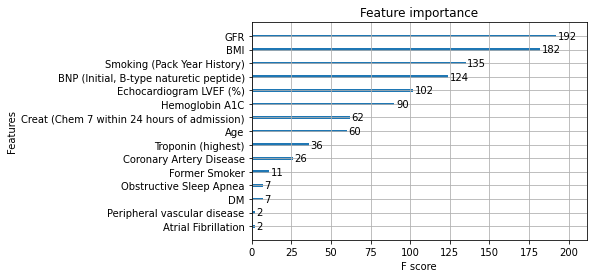

In [ ]:
xgb.plot_importance(model)

Finally, we can save this model.

In [ ]:
model.save_model('/content/drive/My Drive/Heart Failure AI/modelName.model')

After a model is trained and saved, we want a way to be able to reload the model from file rather than training it from scratch again.

In [ ]:
bst = xgb.Booster()
    bst.load_model('/content/drive/My Drive/Heart Failure AI/modelName.model')

    outputTrainPredict = bst.predict(trainMatrix)
    outputTestPredict = bst.predict(testMatrix)

    print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
    print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

    print(classification_report(outputTest, outputTestPredict.round()))
    print("\nConfusion Matrix: ")
    print(pd.crosstab(outputTest, outputTestPredict.round()))
    xgb.plot_importance(model)

This module is only for convenience and allows for training over a long period of time.

In [ ]:
#2D array of parameters we will test by
param_grid = {'eta':[0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 'max_depth':np.arange(1,10,1).tolist(), 'subsample':np.arange(1,0.1,-0.1).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.1).tolist(), 'min_child_weight':np.arange(1,100,10).tolist()}

#Save the best results
bestParams = {}
lowestError = 2048

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:
                    cvResults = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}, trainMatrix, num_boost_round=600, seed=2, nfold=5, early_stopping_rounds=125)
                    if cvResults['test-{}-mean'.format('error')].min() < lowestError:
                        lowestError = cvResults['test-{}-mean'.format('error')].min()
                        bestParams = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}
                    #print(lowestError)
print(bestParams)
print(lowestError)
model = xgb.train(bestParams, trainMatrix, 1000, evals=[(testMatrix, "Test")], early_stopping_rounds=200)
outputTrainPredict = model.predict(trainMatrix)
outputTestPredict = model.predict(testMatrix)

from sklearn.metrics import accuracy_score, classification_report

print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\nConfusion Matrix: ")
print(pd.crosstab(outputTest, outputTestPredict.round()))
print(xgb.plot_importance(model))
model.save_model('/content/drive/My Drive/Heart Failure AI/modelName.model')

KeyboardInterrupt: ignored